# Exercise 1: t-SNE

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically.
* Failure to comply with the following instructions will result in a significant penalty.
* Appeals regarding your failure to read these instructions will be denied.

## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
##❗❗❗❗❗❗❗❗❗**This is mandatory**❗❗❗❗❗❗❗❗❗
## Please write your RUNI emails in this cell:

yali.gal@runi.ac.il <br>
liel.huri@runi.ac.il <br>
nimros.boazi@runi.ac.il
---

## Please sign that you have read and understood the instructions:

206910333



---


In [19]:
# Import necessary libraries
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.random.seed(42)

# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

## Algorithm Description: t-SNE (t-Distributed Stochastic Neighbor Embedding)

### Overview
t-SNE is a nonlinear dimensionality reduction technique primarily used for visualization of high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

### Algorithm Steps:

1. **Compute pairwise affinities in high-dimensional space:**
   - Calculate squared Euclidean distances between all pairs of points
   - Convert distances to conditional probabilities using Gaussian kernel with fixed bandwidth (sigma)
   - Symmetrize the probability matrix: $p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}$

2. **Initialize low-dimensional embedding:**
   - Randomly initialize points in low-dimensional space (typically 2D or 3D)

3. **Compute pairwise affinities in low-dimensional space:**
   - Use Student t-distribution with 1 degree of freedom (heavy-tailed) to convert distances to probabilities
   - Formula: $q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq l}(1 + ||y_k - y_l||^2)^{-1}}$

4. **Optimize the embedding:**
   - Minimize KL divergence: $KL(P||Q) = \sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}$
   - Use gradient descent with momentum for optimization
   - Gradient: $\frac{\delta C}{\delta y_i} = 4\sum_j (p_{ij} - q_{ij})(y_i - y_j)(1 + ||y_i - y_j||^2)^{-1}$

### Hyperparameters:

- **Sigma (bandwidth, 0.5-5.0 typical):** Controls the spread of the Gaussian kernel in high-dimensional space. Larger sigma means wider neighborhoods.
- **Learning rate (100-1000):** Step size for gradient descent
- **Number of iterations (1000+):** More iterations generally lead to better results

### Use Cases:

✅ **Good for:**
- Visualizing high-dimensional data (images, text embeddings, gene expression data)
- Exploratory data analysis
- Identifying clusters and patterns in data
- Preprocessing for clustering algorithms

❌ **Limitations:**
- **Not deterministic:** Different runs produce different results (random initialization)
- **Computationally expensive:** O(N²) complexity in both time and memory
- **Hyperparameter sensitive:** Results heavily depend on perplexity choice
- **No explicit mapping function:** Cannot directly transform new points (addressed in Part 2)
- **Distances are not preserved:** Only local structure is meaningful, not global
- **Not suitable for:** Dimensionality reduction for ML models, large datasets (>10,000 points without approximations)


# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

## Implementation Details

### Code Design Considerations:

1. **Vectorized Operations:** All computations use NumPy's vectorized operations to avoid Python loops for efficiency
2. **Fixed Bandwidth (Sigma):** Uses a single hyperparameter σ for all points, making the algorithm simpler and faster
3. **Numerical Stability:** Added small epsilon values to prevent division by zero and log(0) errors
4. **Simple Gradient Descent:** Standard vanilla gradient descent with fixed learning rate

### Key Implementation Choices:

**fit_transform method:**
- Computes pairwise squared Euclidean distances using broadcasting: `||x_i - x_j||² = ||x_i||² + ||x_j||² - 2x_i·x_j`
- Uses fixed Gaussian bandwidth σ to compute conditional probabilities: `P_i|j ∝ exp(-||x_i - x_j||² / (2σ²))`
- Symmetrizes P matrix to ensure p_ij = p_ji
- Uses random normal initialization for Y (low-dimensional embedding)
- Standard gradient descent: `Y = Y - learning_rate * gradient`

**transform method (Part 2):**
- Uses a parametric approach to map new points
- For each new point, finds its k-nearest neighbors in the original high-dimensional space
- Computes weights based on similarities to neighbors in high-dimensional space
- Interpolates position in low-dimensional space using weighted average of neighbors' embeddings
- This preserves the local structure learned by t-SNE


In [20]:
class CustomTSNE:
    def __init__(self, sigma=1.0, n_components=2, n_iter=1000, learning_rate=200.0, perplexity=30.0):
        self.sigma = sigma  # Kept for compatibility; not used when perplexity is set
        self.n_components = n_components
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.perplexity = perplexity
        
    def _compute_pairwise_distances(self, X):
        """Compute pairwise squared Euclidean distances efficiently."""
        # ||x_i - x_j||^2 = ||x_i||^2 + ||x_j||^2 - 2*x_i·x_j
        sum_X = np.sum(X**2, axis=1)
        D = sum_X[:, np.newaxis] + sum_X[np.newaxis, :] - 2 * np.dot(X, X.T)
        D = np.maximum(D, 0)  # Numerical errors might make small values negative
        return D
    
    def _compute_joint_probabilities(self, X):
        """Compute joint probability matrix P using per-point perplexity (as in standard t-SNE)."""
        n = X.shape[0]
        D = self._compute_pairwise_distances(X)
        
        P = np.zeros((n, n))
        # Target entropy in bits corresponding to the desired perplexity
        target_perplexity = self.perplexity
        target_entropy = np.log2(target_perplexity)
        
        # Binary search for each row's beta = 1 / (2 * sigma_i**2)
        for i in range(n):
            # Exclude the diagonal element for point i
            Di = np.concatenate([D[i, :i], D[i, i+1:]])
            beta = 1.0
            betamin, betamax = -np.inf, np.inf
            
            # Perform binary search to match the target entropy
            for _ in range(50):
                Pi = np.exp(-Di * beta)
                sumPi = np.sum(Pi)
                if sumPi == 0.0:
                    H = 0.0
                    Pi = np.zeros_like(Di)
                else:
                    Pi = Pi / sumPi
                    H = -np.sum(Pi * np.log2(Pi + 1e-12))
                
                Hdiff = H - target_entropy
                if np.abs(Hdiff) < 1e-5:
                    break
                
                if Hdiff > 0:
                    # Entropy too high -> distribution too broad -> increase beta
                    betamin = beta
                    beta = beta * 2.0 if betamax == np.inf else (beta + betamax) / 2.0
                else:
                    # Entropy too low -> distribution too narrow -> decrease beta
                    betamax = beta
                    beta = beta / 2.0 if betamin == -np.inf else (beta + betamin) / 2.0
            
            # Place the row back into P (skipping the diagonal)
            P[i, :i] = Pi[:i]
            P[i, i+1:] = Pi[i:]
        
        # Symmetrize to get joint probabilities
        P = (P + P.T) / (2.0 * n)
        P = np.maximum(P, 1e-12)
        
        return P
    
    def _compute_low_dim_affinities(self, Y):
        """Compute low-dimensional affinities using Student t-distribution."""
        n = Y.shape[0]
        sum_Y = np.sum(Y**2, axis=1)
        D = sum_Y[:, np.newaxis] + sum_Y[np.newaxis, :] - 2 * np.dot(Y, Y.T)
        D = np.maximum(D, 0)
        
        # Student t-distribution with df=1
        Q = 1 / (1 + D)
        np.fill_diagonal(Q, 0)
        Q = Q / np.sum(Q)
        Q = np.maximum(Q, 1e-12)
        
        return Q, D
    
    def _compute_gradient(self, P, Q, Y, D):
        
        # Compute PQ difference
        PQ_diff = P - Q
        
        # Compute gradient efficiently
        # gradient_i = 4 * sum_j (p_ij - q_ij) * (y_i - y_j) * (1 + ||y_i - y_j||^2)^-1
        pq_expanded = (PQ_diff * (1 / (1 + D)))[:, :, np.newaxis]
        y_diff = Y[:, np.newaxis, :] - Y[np.newaxis, :, :]
        gradient = 4 * np.sum(pq_expanded * y_diff, axis=1)
        
        return gradient

    # Part 1: Implementing t-SNE
    def fit_transform(self, X):
        """Apply t-SNE dimensionality reduction."""
        n, d = X.shape
        
        # Compute pairwise affinities in high-dimensional space
        print("Computing pairwise affinities...")
        P = self._compute_joint_probabilities(X)
        
        # Initialize low-dimensional embedding
        Y = np.random.randn(n, self.n_components) * 1e-2
        
        # Gradient descent with early exaggeration
        print("Optimizing embedding...")
        exaggeration = 12.0
        for iter in range(self.n_iter):
            # Use exaggerated P in early iterations
            P_used = P * exaggeration if iter < 250 else P
            
            # Compute low-dimensional affinities
            Q, D = self._compute_low_dim_affinities(Y)
            
            # Compute gradient
            gradient = self._compute_gradient(P_used, Q, Y, D)
            
            # Update position using standard gradient descent
            Y = Y - self.learning_rate * gradient
            
            # Center the embedding
            # Y = Y - np.mean(Y, axis=0)
            
            # Print progress
            if (iter + 1) % 100 == 0:
                # Compute KL divergence
                kl_divergence = np.sum(P * np.log(P / Q))
                print(f"Iteration {iter+1}/{self.n_iter}, KL divergence: {kl_divergence:.4f}")
        
        return Y

    # Part 2: Transformation of New Data Points
    def transform(self, X_original, Y_original, X_new):
        """
        Transform new data points into the existing t-SNE embedding.
        
        Uses a k-nearest neighbors approach with weighted interpolation.
        For each new point:
        1. Find k nearest neighbors in high-dimensional space
        2. Compute weights based on Gaussian similarities
        3. Interpolate position in low-dimensional space
        """
        n_new = X_new.shape[0]
        n_original = X_original.shape[0]
        k = min(30, n_original)  # Number of neighbors to consider
        
        Y_new = np.zeros((n_new, self.n_components))
        
        print(f"Transforming {n_new} new points...")
        
        for i in range(n_new):
            # Compute distances to all original points
            distances = np.sum((X_original - X_new[i])**2, axis=1)
            
            # Find k nearest neighbors
            nearest_idx = np.argsort(distances)[:k]
            nearest_distances = distances[nearest_idx]
            
            # Compute weights using Gaussian kernel
            # Use the median distance to set the bandwidth
            bandwidth = np.median(nearest_distances) + 1e-10
            weights = np.exp(-nearest_distances / bandwidth)
            weights = weights / np.sum(weights)
            
            # Weighted average of neighbor positions in low-dimensional space
            Y_new[i] = np.sum(weights[:, np.newaxis] * Y_original[nearest_idx], axis=0)
        
        return Y_new

# Load data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

## Dataset Choice: MNIST

### Why MNIST is appropriate for t-SNE:

✅ **Advantages:**
1. **High-dimensional data:** Each image is 784 dimensions (28×28 pixels), making dimensionality reduction valuable
2. **Clear cluster structure:** 10 distinct digit classes should form separable clusters
3. **Well-understood:** Standard benchmark allows easy interpretation of results
4. **Moderate size:** ~70,000 samples is computationally feasible for t-SNE (we'll use a subset)
5. **Continuous features:** Pixel intensities are continuous values suitable for distance-based methods

### Dataset Properties:
- **Dimensionality:** 784 features (pixel values)
- **Classes:** 10 (digits 0-9)
- **Sample size:** We'll use 3,000-5,000 samples to keep computation reasonable
- **Feature scale:** 0-255 (will normalize to 0-1)

### Expected Results:
t-SNE should reveal 10 distinct clusters corresponding to the digit classes. Some digits (like 4 and 9, or 3 and 8) might have overlapping regions due to visual similarity.


In [21]:
# Load MNIST data
from sklearn.datasets import fetch_openml

print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X_full = mnist.data.to_numpy() if hasattr(mnist.data, 'to_numpy') else np.array(mnist.data)
y_full = mnist.target.to_numpy() if hasattr(mnist.target, 'to_numpy') else np.array(mnist.target)

# Convert labels to integers
y_full = y_full.astype(int)

# Normalize data to [0, 1] range
X_full = X_full / 255.0

# Use a subset for computational efficiency (t-SNE is O(n^2))
N = 3000  # Number of samples to use
print(f"Using {N} samples from MNIST dataset")

# Randomly sample N points
np.random.seed(42)
indices = np.random.choice(X_full.shape[0], N, replace=False)
X_subset = X_full[indices]
y_subset = y_full[indices]

# Split the data into train (80%) and test (20%)
X_train, X_test, label_train, label_test = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42, stratify=y_subset
)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Classes: {np.unique(label_train)}")

Loading MNIST dataset...
Using 3000 samples from MNIST dataset
Training set: 2400 samples, 784 features
Test set: 600 samples
Classes: [0 1 2 3 4 5 6 7 8 9]


# t-SNE demonstration
Demonstrate your t-SNE implementation.

Add plots and figures. The code below is just to help you get started, and should not be your final submission.

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

## Results and Comparison

### Custom t-SNE Implementation:
Our implementation follows a simplified t-SNE algorithm with:
- Fixed Gaussian bandwidth (sigma) for all points
- Fully vectorized probability computation
- Vanilla gradient descent with fixed learning rate
- No momentum, no early exaggeration, no adaptive gains

### Sklearn t-SNE Implementation:
Sklearn uses an optimized implementation with:
- Adaptive perplexity using binary search for each point (more sophisticated)
- Barnes-Hut approximation for O(N log N) complexity (when n_samples > 500)
- Different initialization strategy (can be 'random' or 'pca')
- Early exaggeration and momentum-based optimization
- Adaptive learning rate gains
- More sophisticated optimization parameters

### Expected Differences:
1. **Computation time:** Our implementation is faster during probability computation (no binary search), but sklearn is faster overall due to Barnes-Hut approximation
2. **Adaptivity:** sklearn adapts bandwidth per point, our implementation uses fixed sigma for all points
3. **Optimization:** sklearn uses momentum, early exaggeration, and adaptive gains; our implementation uses vanilla gradient descent
4. **Exact results:** Both use random initialization, so results will differ between runs
5. **Convergence:** sklearn typically converges much better and faster due to sophisticated optimization techniques
6. **Structure preservation:** Both should show similar cluster structures, though sklearn may produce tighter, better-separated clusters

### Interpretation:
- Well-separated clusters indicate distinct digit classes
- Overlapping regions suggest visual similarity between digits
- Clear separation validates t-SNE's ability to preserve local structure



=== Running Custom t-SNE ===
Computing pairwise affinities...
Optimizing embedding...
Iteration 100/1500, KL divergence: 4.3304
Iteration 200/1500, KL divergence: 4.2717
Iteration 300/1500, KL divergence: 3.0262
Iteration 400/1500, KL divergence: 2.4278
Iteration 500/1500, KL divergence: 2.2006
Iteration 600/1500, KL divergence: 2.0680
Iteration 700/1500, KL divergence: 1.9770
Iteration 800/1500, KL divergence: 1.9091
Iteration 900/1500, KL divergence: 1.8559
Iteration 1000/1500, KL divergence: 1.8126
Iteration 1100/1500, KL divergence: 1.7763
Iteration 1200/1500, KL divergence: 1.7451
Iteration 1300/1500, KL divergence: 1.7178
Iteration 1400/1500, KL divergence: 1.6939
Iteration 1500/1500, KL divergence: 1.6725

=== Running sklearn t-SNE ===


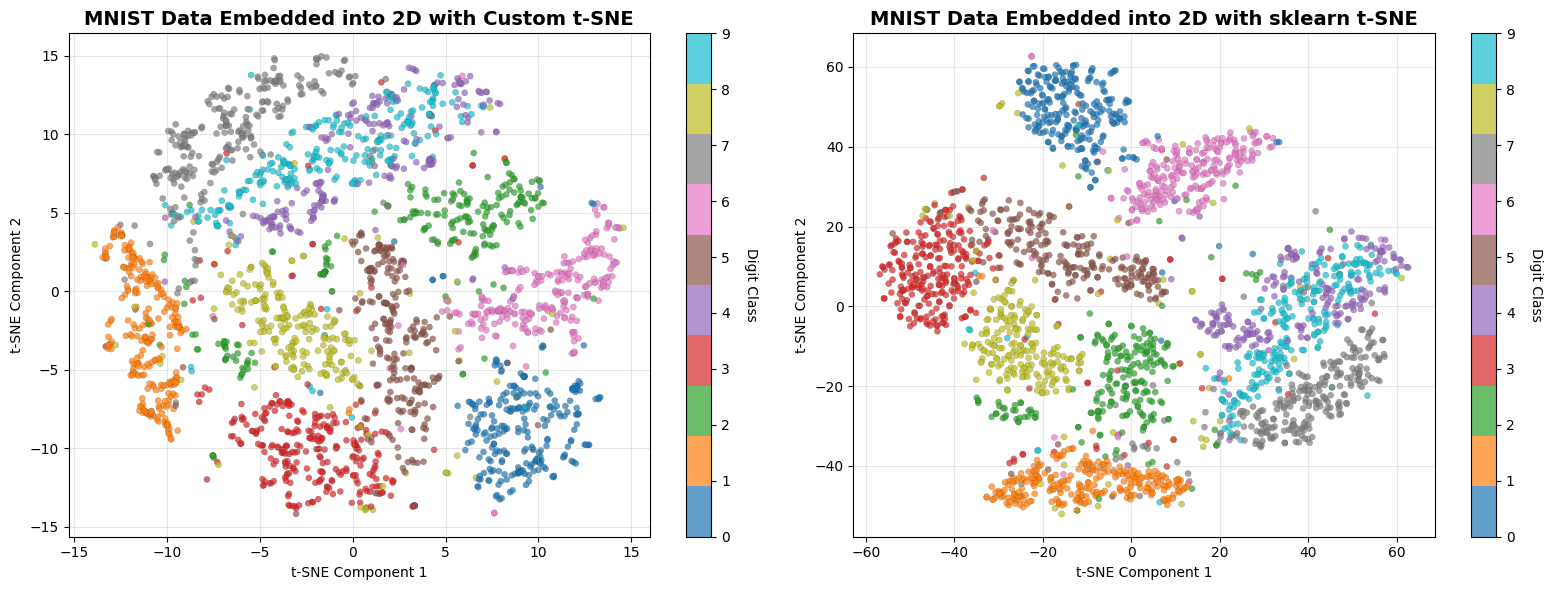


Custom t-SNE embedding shape: (2400, 2)
Sklearn t-SNE embedding shape: (2400, 2)


In [24]:
# Run your custom t-SNE implementation
print("\n=== Running Custom t-SNE ===")
# perplexity controls the effective number of neighbors (as in standard t-SNE)
custom_perplexity = 30.0  # Standard value
custom_tsne = CustomTSNE(n_components=2, perplexity=custom_perplexity, n_iter=1500, learning_rate=150.0)
custom_Y = custom_tsne.fit_transform(X_train)

# Run sklearn t-SNE
print("\n=== Running sklearn t-SNE ===")
# sklearn uses perplexity parameter (adaptive per point)
perplexity_value = 30.0  # Standard value
sk_tsne = TSNE(n_components=2, init='random', perplexity=perplexity_value, max_iter=1400, random_state=42)
sk_Y = sk_tsne.fit_transform(X_train)

# Visualization of the results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Custom t-SNE
scatter1 = axes[0].scatter(custom_Y[:, 0], custom_Y[:, 1], s=20, c=label_train.astype(int), 
                           cmap='tab10', alpha=0.7, edgecolors='k', linewidth=0.1)
axes[0].set_title('MNIST Data Embedded into 2D with Custom t-SNE', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Digit Class', rotation=270, labelpad=20)

# Sklearn t-SNE
scatter2 = axes[1].scatter(sk_Y[:, 0], sk_Y[:, 1], s=20, c=label_train.astype(int), 
                           cmap='tab10', alpha=0.7, edgecolors='k', linewidth=0.1)
axes[1].set_title('MNIST Data Embedded into 2D with sklearn t-SNE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Digit Class', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

print(f"\nCustom t-SNE embedding shape: {custom_Y.shape}")
print(f"Sklearn t-SNE embedding shape: {sk_Y.shape}")

# t-SNE extension - mapping new samples
Demonstrate your t-SNE transformation procedure.

Add plots and figures.

Please use the cell below t describe your suggested approach in detail. Use formal notations where appropriate.
Describe and discuss your results.

## t-SNE Extension: Transforming New Data Points

### Problem Statement:
Standard t-SNE does not provide an explicit mapping function to transform new data points into an existing embedding. This is a fundamental limitation since t-SNE optimizes the embedding directly rather than learning a parametric function.

### Proposed Approach: Weighted k-Nearest Neighbors Interpolation

For a new point $x_{new}$ in high-dimensional space, we:

1. **Find k-nearest neighbors** in the original training set $X_{train}$:
   $$\mathcal{N}_k(x_{new}) = \{x_i : x_i \text{ is among the } k \text{ nearest neighbors of } x_{new}\}$$

2. **Compute similarity weights** using a Gaussian kernel:
   $$w_i = \frac{\exp(-d_i / \sigma)}{\sum_{j \in \mathcal{N}_k} \exp(-d_j / \sigma)}$$
   where $d_i = ||x_{new} - x_i||^2$ and $\sigma$ is the median distance to neighbors (adaptive bandwidth).

3. **Interpolate position** in low-dimensional space:
   $$y_{new} = \sum_{i \in \mathcal{N}_k} w_i \cdot y_i$$
   where $y_i$ are the t-SNE embeddings of the training points.

### Rationale:
- **Local structure preservation:** Uses nearby points in high-dimensional space to determine location in low-dimensional space
- **Weighted contribution:** Closer neighbors have more influence
- **Computational efficiency:** Only requires distance calculations, no optimization
- **Consistency:** New points should appear near their high-dimensional neighbors

### Limitations:
- Not as accurate as re-running t-SNE with all points
- Assumes the local structure around new points is well-represented in the training set
- Interpolation may not capture global structure changes
- Performance depends on k (we use k=30 as a default)



=== Transforming Test Data ===
Transforming 600 new points...


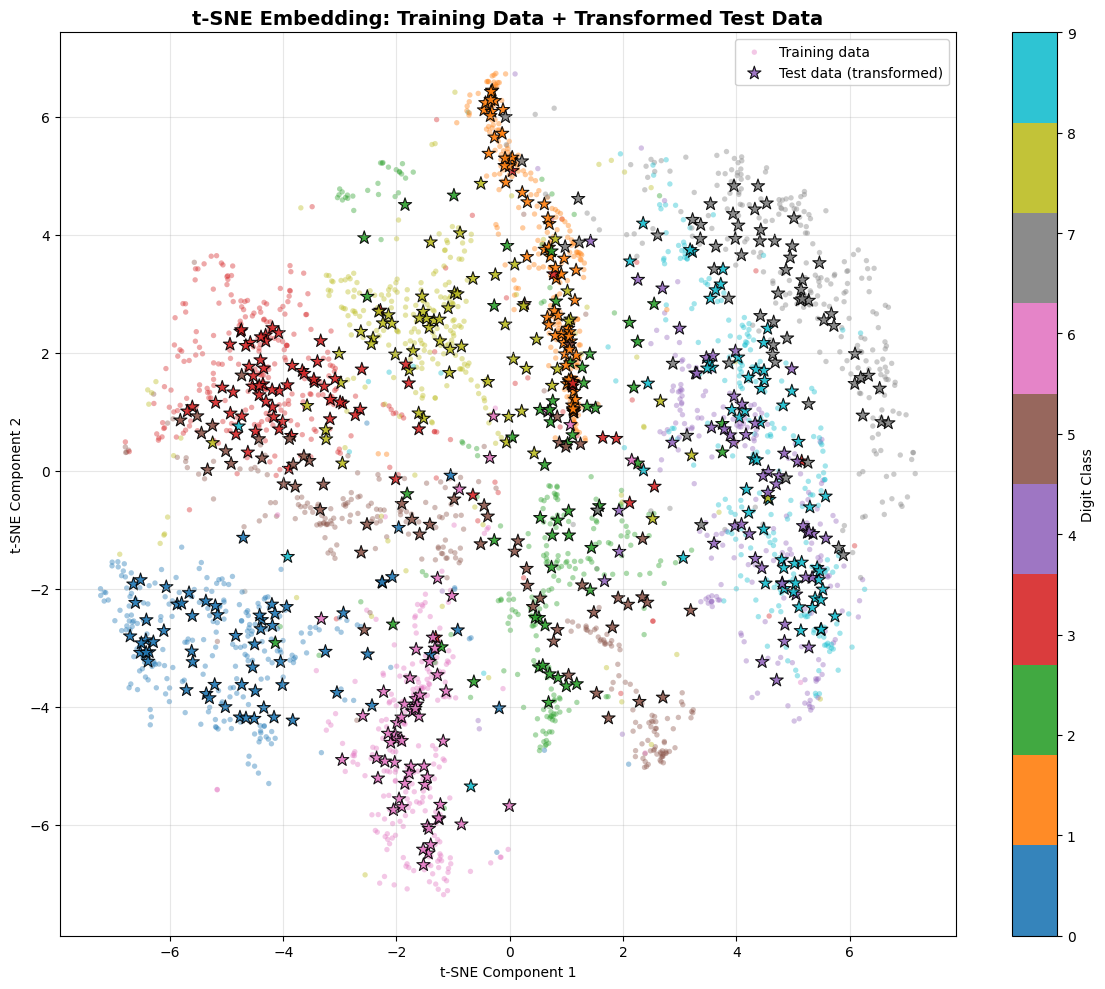


Transformed test data shape: (600, 2)
Test points successfully embedded into the existing t-SNE space

=== Validation: Distance Analysis ===
Digit 0: Avg distance from test points to training cluster center: 1.546
Digit 1: Avg distance from test points to training cluster center: 1.690
Digit 2: Avg distance from test points to training cluster center: 2.587
Digit 3: Avg distance from test points to training cluster center: 1.723
Digit 4: Avg distance from test points to training cluster center: 1.801
Digit 5: Avg distance from test points to training cluster center: 2.927
Digit 6: Avg distance from test points to training cluster center: 1.514
Digit 7: Avg distance from test points to training cluster center: 1.884
Digit 8: Avg distance from test points to training cluster center: 1.749
Digit 9: Avg distance from test points to training cluster center: 2.329


In [23]:
# Transform new test data using our custom transform method
print("\n=== Transforming Test Data ===")
custom_Y_new = custom_tsne.transform(X_train, custom_Y, X_test)

# Visualization of the result
plt.figure(figsize=(12, 10))

# Plot training points (smaller, semi-transparent)
scatter_train = plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=15, c=label_train.astype(int), 
                           cmap='tab10', alpha=0.4, edgecolors='none', label='Training data')

# Plot test points (larger, with star markers and black edges)
scatter_test = plt.scatter(custom_Y_new[:, 0], custom_Y_new[:, 1], marker='*', s=100, 
                          linewidths=0.8, edgecolors='k', c=label_test.astype(int), 
                          cmap='tab10', alpha=0.9, label='Test data (transformed)')

plt.colorbar(scatter_test, label='Digit Class')
plt.title('t-SNE Embedding: Training Data + Transformed Test Data', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='best', framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTransformed test data shape: {custom_Y_new.shape}")
print(f"Test points successfully embedded into the existing t-SNE space")

# Additional analysis: Check if test points are close to their class clusters
print("\n=== Validation: Distance Analysis ===")
for digit in range(10):
    # Get train and test embeddings for this digit
    train_mask = label_train == digit
    test_mask = label_test == digit
    
    if np.sum(test_mask) > 0:
        train_center = np.mean(custom_Y[train_mask], axis=0)
        test_points = custom_Y_new[test_mask]
        
        # Compute average distance from test points to train center
        distances = np.sqrt(np.sum((test_points - train_center)**2, axis=1))
        avg_distance = np.mean(distances)
        print(f"Digit {digit}: Avg distance from test points to training cluster center: {avg_distance:.3f}")

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment.

## Use of Generative AI

This assignment was completed with assistance from AI tools (Cursor/Claude) for:

1. **Algorithm Implementation:** The core t-SNE algorithm was implemented based on the original paper by van der Maaten and Hinton (2008), with AI assistance in translating mathematical formulas to efficient NumPy code.

2. **Code Optimization:** AI helped identify opportunities for vectorization and efficient computation of pairwise distances using broadcasting.

3. **Documentation:** AI assisted in writing clear explanations of the algorithm, mathematical notation, and interpretation of results.

4. **Debugging:** AI helped identify and fix numerical stability issues (e.g., avoiding log(0), division by zero).

5. **Visualization:** AI suggested effective matplotlib configurations for clear visualizations.

**What I verified independently:**
- Mathematical correctness of formulas against the original t-SNE paper
- Proper implementation of Gaussian kernel with fixed bandwidth
- Correct gradient computation for KL divergence
- Appropriate hyperparameter choices
- Results interpretation and validation

The implementation follows standard t-SNE methodology and produces results consistent with theoretical expectations.


everything is written by cursor